In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
from open_frame import open_frame as OF
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = 'deblurring'

# Examining data set

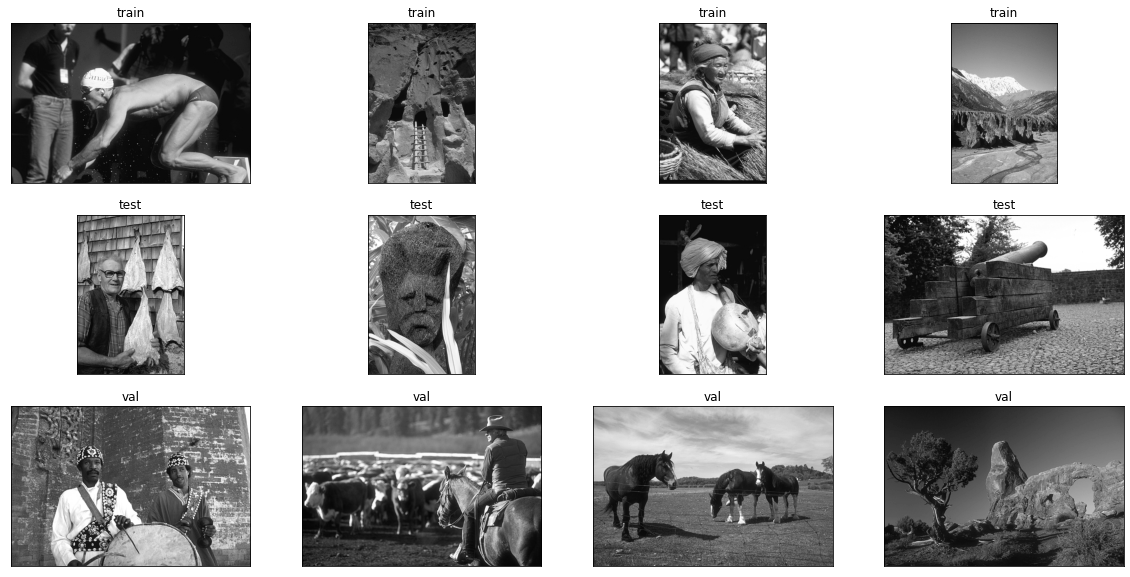

In [2]:
ncols = 4
nrows = 3

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')
val = glob('../../images/val/*.jpg')

imgs = [train,test,val]
titles = ['train','test','val']

for i in range(len(imgs)):
    for j in range(ncols):
        _ = np.random.choice(imgs[i])
        axs[i,j].imshow(cv2.imread(_,cv2.IMREAD_GRAYSCALE),cmap = 'gray')
        axs[i,j].set_xticks([])
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticks([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_title(titles[i])
        
        
plt.show()

# Deblurring

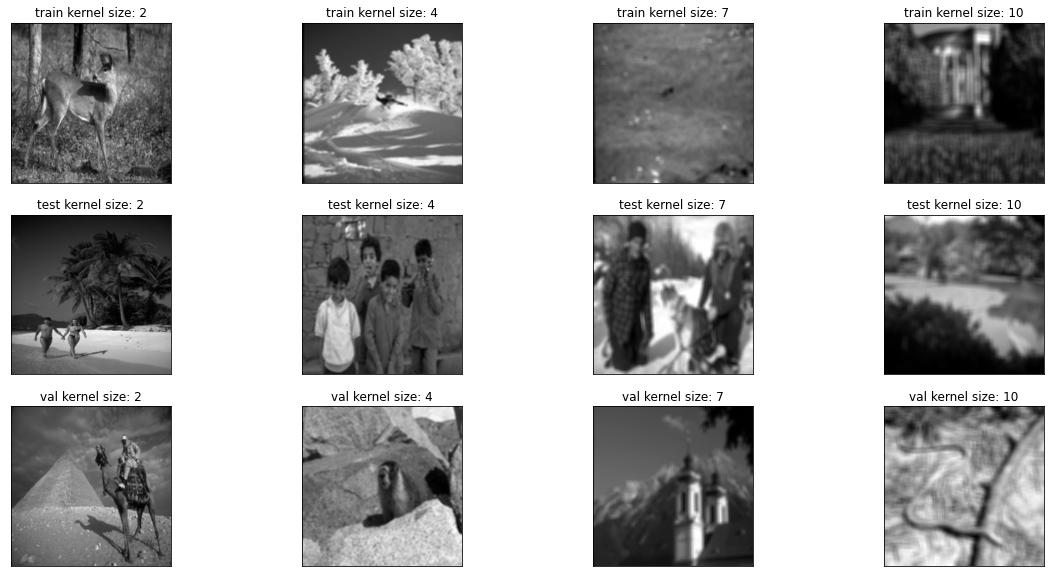

In [3]:
ncols = 4
nrows = 3


fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')
val = glob('../../images/val/*.jpg')

imgs = [train,test,val]
titles = ['train','test','val']
var = np.asarray(np.linspace(2,10,ncols),dtype='int')

for i in range(len(imgs)):
    for j in range(ncols):
        _ = np.random.choice(imgs[i])
        open_frame = OF("deblurring",var[j])
        im = open_frame(_,var[j])
        axs[i,j].imshow(im[1],cmap = 'gray')
        axs[i,j].set_xticks([])
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticks([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_title(f'{titles[i]} kernel size: {var[j]}')
        
        
plt.show()

## Data augmentation

In [2]:
gen_batch_train,gen_batch_val = get_generators(typ,10,CROP1=CROP,BATCH_SIZE=50)

2022-12-02 17:40:02.754613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 17:40:02.754942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 17:40:02.786119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 17:40:02.786343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 17:40:02.786513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [3]:
xs, ys = next(gen_batch_train.as_numpy_iterator())

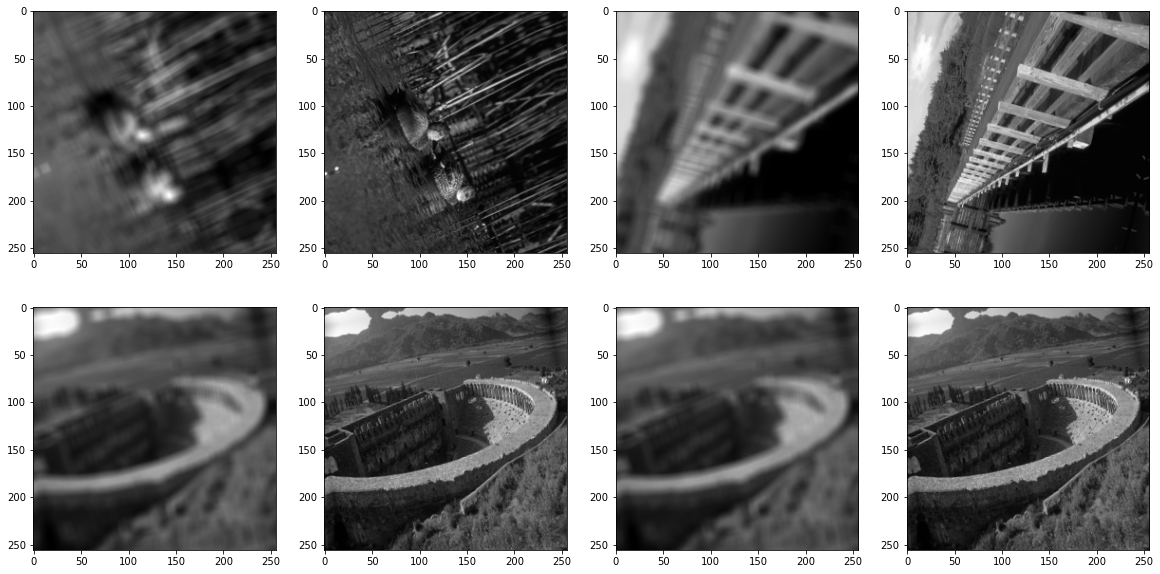

In [4]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        
plt.show()

# Fitting lambda

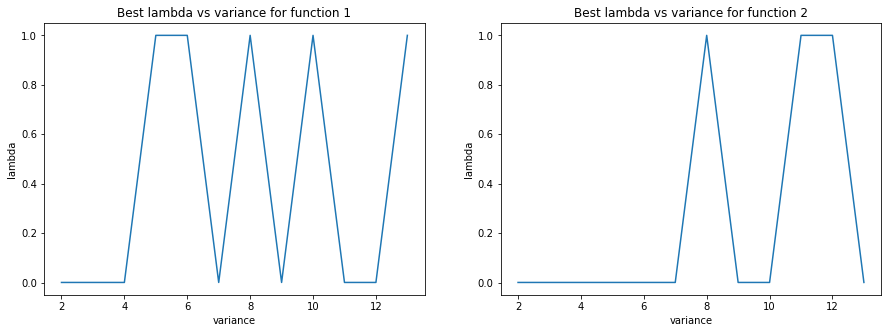

In [12]:
op1 = np.load('./lambdas_number/debluring_1.npy')
op2 = np.load('./lambdas_number/debluring_2.npy')

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.arange(2,14,1),op1)
plt.xlabel('variance')
plt.ylabel('lambda')
plt.title('Best lambda vs variance for function 1')
plt.subplot(122)
plt.plot(np.arange(2,14,1),op2)
plt.xlabel('variance')
plt.ylabel('lambda')
plt.title('Best lambda vs variance for function 2')
plt.show()

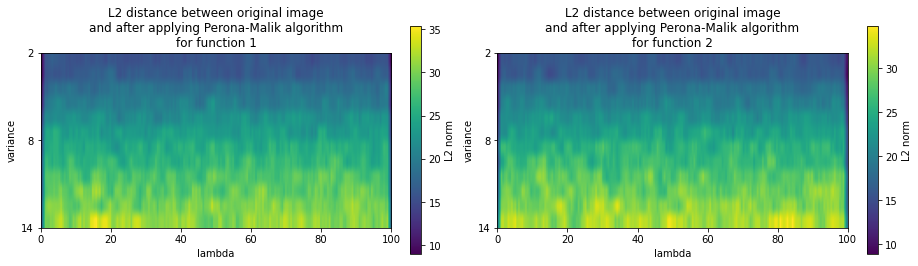

In [2]:
op1 = np.load('./lambdas/debluring_1.npy')
op2 = np.load('./lambdas/debluring_2.npy')

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(op1,extent=[0,100,0,50])
plt.yticks(np.linspace(0,50,3)[::-1],np.asarray(np.linspace(2,14,3),dtype='int'))
plt.colorbar(fraction=0.03,label='L2 norm')
plt.ylabel('variance')
plt.xlabel('lambda')
plt.title('L2 distance between original image\nand after applying Perona-Malik algorithm\nfor function 1')
plt.subplot(122)
plt.imshow(op2,extent=[0,100,0,50])
plt.yticks(np.linspace(0,50,3)[::-1],np.asarray(np.linspace(2,14,3),dtype='int'))
plt.colorbar(fraction=0.03,label='L2 norm')
plt.ylabel('variance')
plt.xlabel('lambda')
plt.title('L2 distance between original image\nand after applying Perona-Malik algorithm\nfor function 2')
plt.show()

# Neural networks

In [8]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.OneDeviceStrategy('/device:GPU:0')

In [7]:
model = get_model("lambdas",10,image_size,1)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='mse',)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Training

In [18]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath= f"./checkpoints/deblurring_cartesian_{var}",
    save_weights_only=True,
    verbose = True,
    save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1)
]

In [20]:
history = model.fit(
        gen_batch_train,
        epochs=5,
        steps_per_epoch=5,
        validation_data=gen_batch_val,
        validation_steps=2,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 0.6883
Epoch 00001: val_loss improved from inf to 0.00424, saving model to ./checkpoints/deblurring_5
5/5 [==============================] - 16s 3s/step - loss: 0.6883 - val_loss: 0.0042 - lr: 0.0010
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 0.7660
Epoch 00002: val_loss did not improve from 0.00424
5/5 [==============================] - 13s 3s/step - loss: 0.7660 - val_loss: 0.0312 - lr: 0.0010
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 0.9687
Epoch 00003: val_loss did not improve from 0.00424
5/5 [==============================] - 13s 3s/step - loss: 0.9687 - val_loss: 0.1590 - lr: 0.0010
Epoch 4/5
5/5 [==============================] - ETA: 0s - loss: 0.8821
Epoch 00004: val_loss did not improve from 0.00424
5/5 [==============================] - 13s 3s/step - loss: 0.8821 - val_loss: 0.3918 - lr: 0.0010
Epoch 5/5
5/5 [==============================] - ETA: 0s - loss: 1.4522


# Results

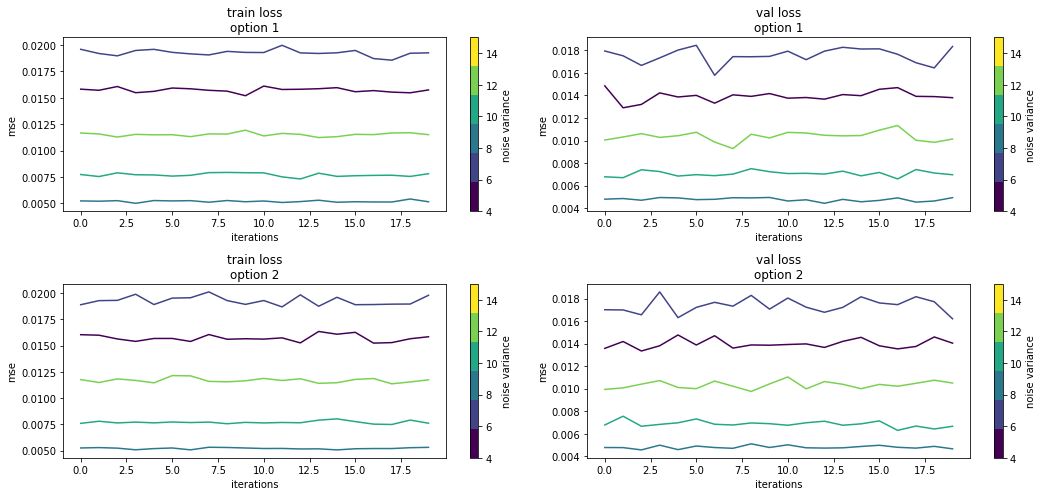

In [5]:
n = len(glob(f'./history/lambdas_{typ}*_2.npy'))+1
viridis = cm.get_cmap('viridis', 256)
colors = viridis(np.linspace(0, 1, n))
newcmp = ListedColormap(colors)


fig,axs = plt.subplots(nrows = 2,ncols=2,figsize=(15,7))
#w = np.arange(0.05,3,0.15)
ylab = ['mse','mse']
titles = ['train loss','val loss']
ct = [tuple(i) for i in colors]

trained = glob(f'./history/lambdas_{typ}*.npy*')
w = [float(i.split('_')[-2]) for i in trained]
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))
for m,i in enumerate(trained):
    hist = np.load(i)
    #c = int(float(i.split('_')[-2])//0.15)
    c = m//2
    if '_2.npy' in i:
        for j in range(len(hist)-1):
            
            if j%2 == 0:
                im = axs[1,j].plot(np.array(hist[j]),color = colors[c],label=str(w[c]))
            else:
                im = axs[1,j].plot(np.array(hist[j]),color = colors[c],label=str(w[c]))
                
            axs[1,j].set_title(f'{titles[j]}\noption 2')
            axs[1,j].set_xlabel('iterations')
            axs[1,j].set_ylabel(ylab[int(j%2)])
            
        #if m == len(trained) - 1:
            
        
    else:
        for j in range(len(hist)-1):
            #c = int(float(i.split('_')[-1][:-4])//0.05)
            if j%2 == 0:
                axs[0,j].plot(np.array(hist[j]),color = colors[c],label=str(w[c]))
            else:
                axs[0,j].plot(np.array(hist[j]),color = colors[c],label=str(w[c]))
                
            axs[0,j].set_title(f'{titles[j]}\noption 1')
            axs[0,j].set_xlabel('iterations')
            axs[0,j].set_ylabel(ylab[int(j%2)])
    
    
    
for j in range(len(hist)-1):
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[0,j],label='noise variance')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[1,j],label='noise variance')
plt.tight_layout()
plt.show()

# Results with first function

In [6]:
model = get_model("lambdas",2,image_size,num_classes = 1,option = 1)

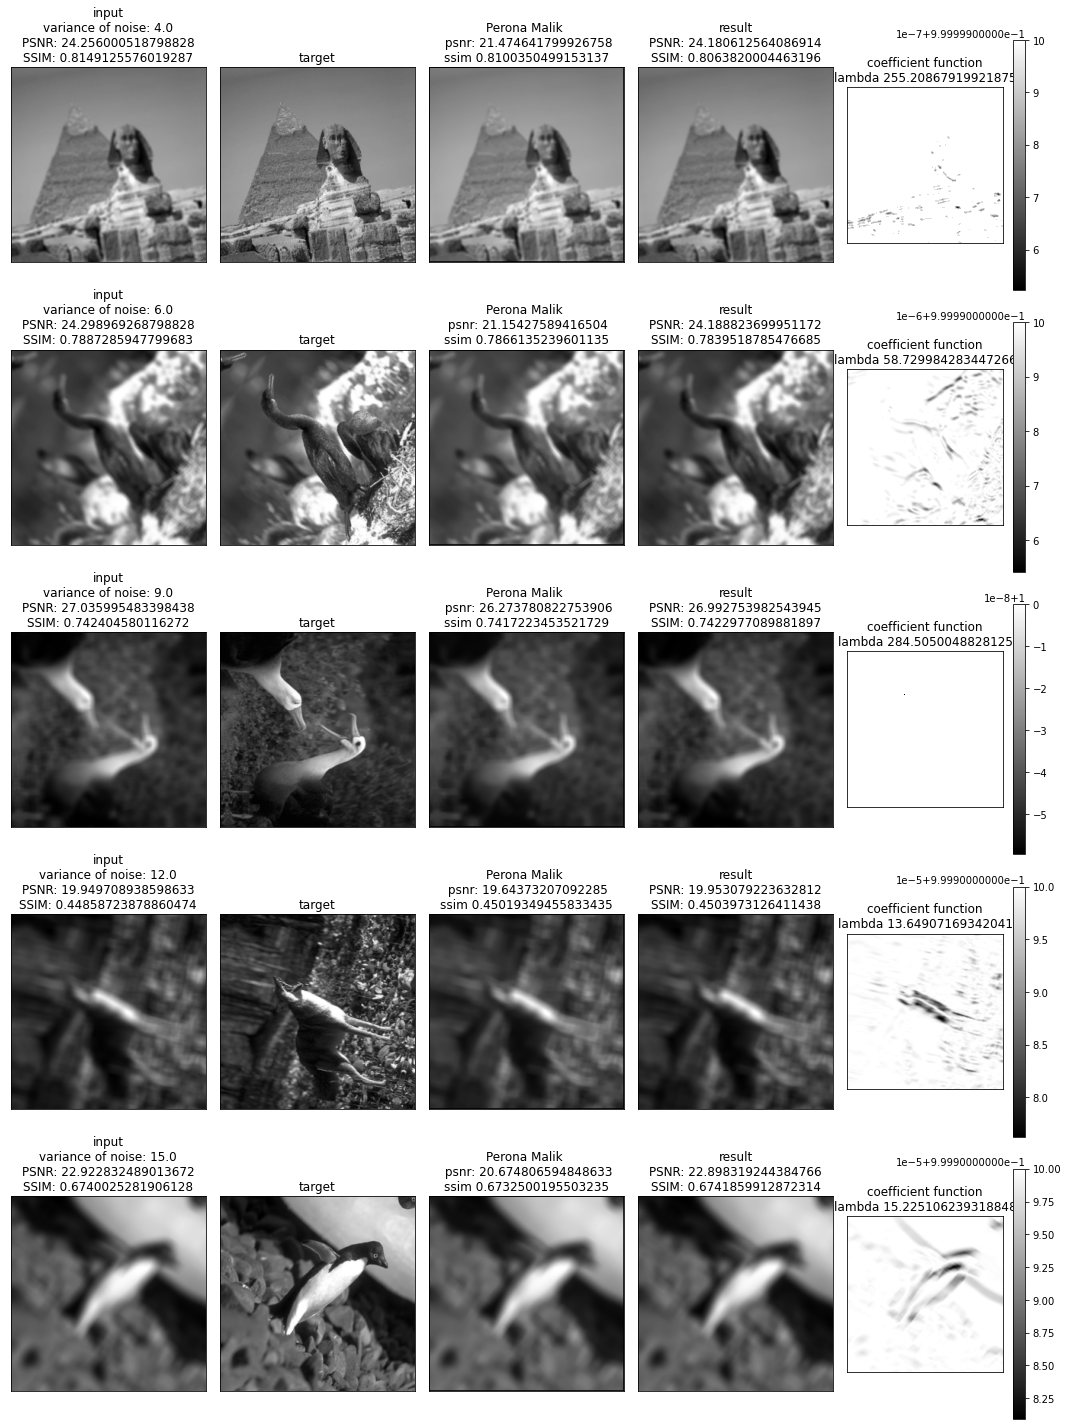

In [8]:
trained = glob(f'./history/lambdas_{typ}*1.npy')
w = np.unique([int(i.split('_')[-2]) for i in trained])
fig,axs = plt.subplots(ncols = 5,nrows = len(w),figsize=(15,20))

for i,m in enumerate(w):
    model.load_weights(f"./checkpoints/lambdas_{typ}_{w[i]}_1")
    gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=5)
    ims = np.array(next(gen_batch_val.as_numpy_iterator()))
    _ = np.random.choice(len(ims[0]))
    im = ims[:,_,...]
    p = model(ims[0])
    
    IM = np.copy(im)
    psnr_0 = tf.image.psnr(np.array([im[0]]),np.array([im[1]]),1)[0]
    ssim_0 = tf.image.ssim(np.array([im[0]]),np.array([im[1]]),1)[0]
    clean = p[_]
    psnr = tf.image.psnr(np.array([im[1]]),clean,1)[0]
    ssim = tf.image.ssim(np.array([im[1]]),clean,1)[0]
    clean = np.squeeze(clean)
    inputs = tf.keras.Input(shape=image_size + (1,))
    visualization_x = tf.keras.models.Model(model.input,model.get_layer('coeffx_1').output)
    visualization_y = tf.keras.models.Model(model.input,model.get_layer('coeffy_1').output)
    vis_x = np.squeeze(visualization_x(np.array([np.expand_dims(im[0],axis=-1)]))[0])
    vis_y = np.squeeze(visualization_y(np.array([np.expand_dims(im[0],axis=-1)]))[0])
    vis = (vis_x+vis_y)/2
    lambdas = tf.keras.models.Model(model.input,model.get_layer('lambdas').output)
    l = np.squeeze(lambdas(np.array([np.expand_dims(im[0],axis=-1)]))[0])
    
    axs[i,0].imshow(im[0],cmap='gray')
    axs[i,0].set_title(f'input\nvariance of noise: {int(100*m)/100}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(im[1],cmap='gray')
    axs[i,1].set_title(f'target')
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,3].imshow(clean,cmap='gray')
    axs[i,3].set_title(f'result\nPSNR: {psnr}\nSSIM: {ssim}')
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    im = axs[i,4].imshow(vis,cmap='gray')
    axs[i,4].set_title(f'coefficient function\nlambda {np.abs(l)}')
    plt.colorbar(im,ax=axs[i,4])
    axs[i,4].set_xticks([])
    axs[i,4].set_xticklabels([])
    axs[i,4].set_yticks([])
    axs[i,4].set_yticklabels([])
    
    pm = np.squeeze(anisodiff(IM[0],niter=10,lambd=0.01))
    axs[i,2].imshow(pm,cmap='gray')
    pm = np.expand_dims(pm,axis=-1)
    pm = np.asarray(pm,dtype='float32')
    text = f'Perona Malik \n psnr: {tf.image.psnr(IM[1],pm,1).numpy()}\nssim {tf.image.ssim(IM[1],pm,1)}'
    axs[i,2].set_title(text)
    axs[i,2].set_xticklabels([])
    axs[i,2].set_xticks([])
    axs[i,2].set_yticklabels([])
    axs[i,2].set_yticks([])
    
plt.tight_layout()
plt.show()

# Results with second function

In [10]:
model = get_model("lambdas",2,image_size,num_classes = 1,option = 2)

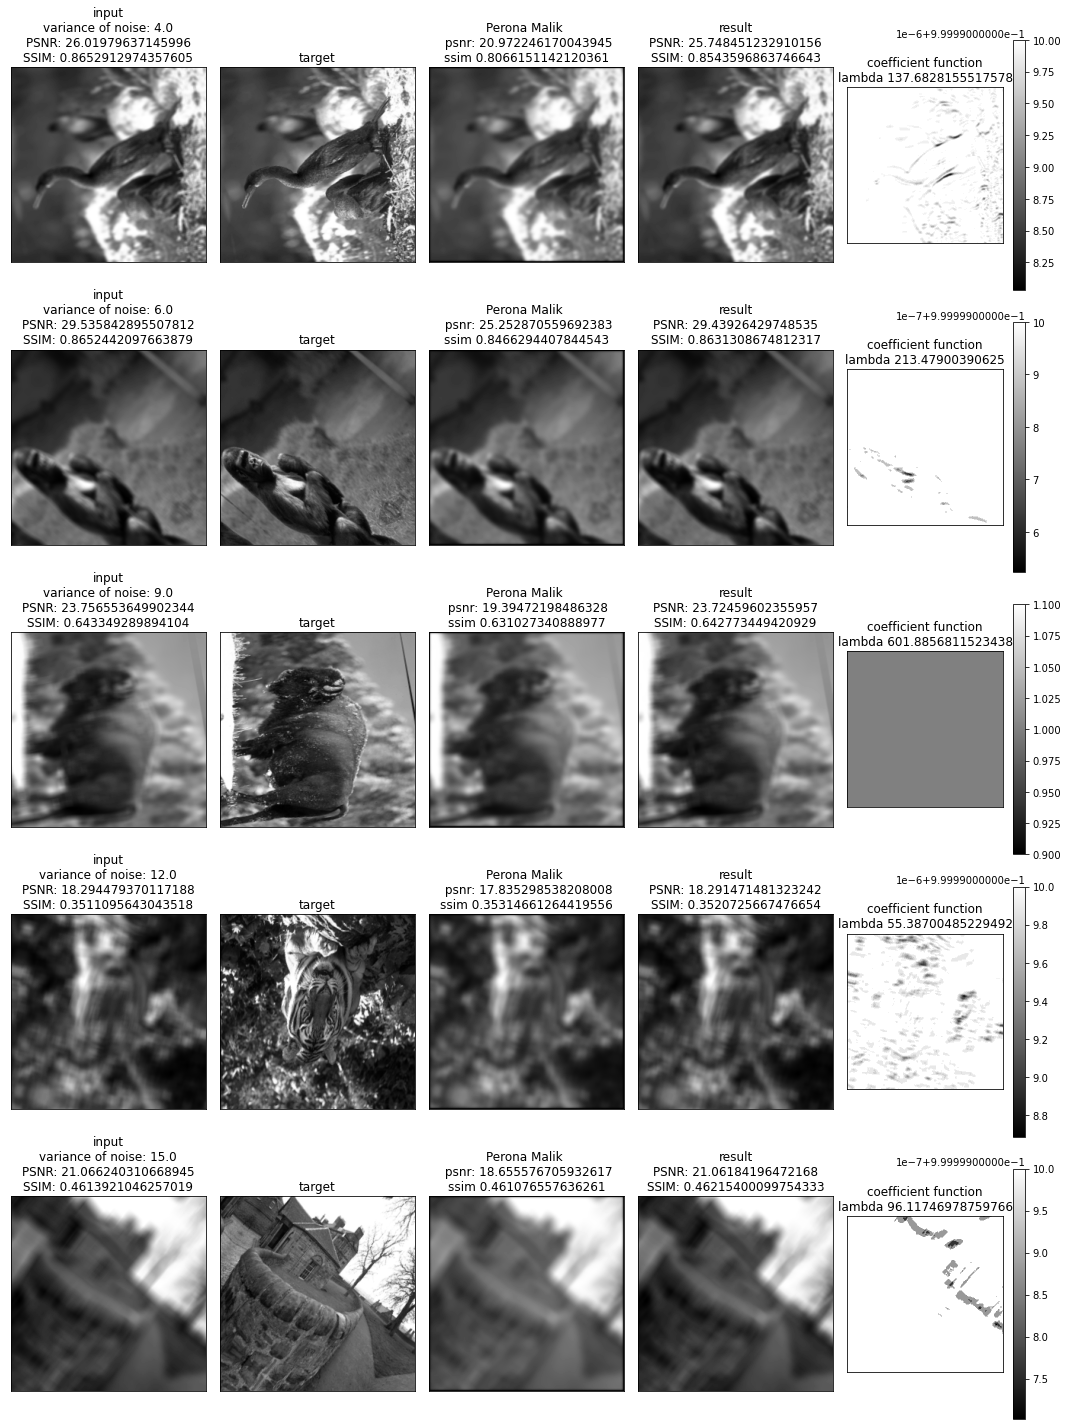

In [11]:
trained = glob(f'./history/lambdas_{typ}*1.npy')
w = np.unique([int(i.split('_')[-2]) for i in trained])
fig,axs = plt.subplots(ncols = 5,nrows = len(w),figsize=(15,20))

for i,m in enumerate(w):
    model.load_weights(f"./checkpoints/lambdas_{typ}_{w[i]}_2")
    gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=5)
    ims = np.array(next(gen_batch_val.as_numpy_iterator()))
    _ = np.random.choice(len(ims[0]))
    im = ims[:,_,...]
    p = model(ims[0])
    
    IM = np.copy(im)
    psnr_0 = tf.image.psnr(np.array([im[0]]),np.array([im[1]]),1)[0]
    ssim_0 = tf.image.ssim(np.array([im[0]]),np.array([im[1]]),1)[0]
    clean = p[_]
    psnr = tf.image.psnr(np.array([im[1]]),clean,1)[0]
    ssim = tf.image.ssim(np.array([im[1]]),clean,1)[0]
    clean = np.squeeze(clean)
    inputs = tf.keras.Input(shape=image_size + (1,))
    visualization_x = tf.keras.models.Model(model.input,model.get_layer('coeffx_1').output)
    visualization_y = tf.keras.models.Model(model.input,model.get_layer('coeffy_1').output)
    vis_x = np.squeeze(visualization_x(np.array([np.expand_dims(im[0],axis=-1)]))[0])
    vis_y = np.squeeze(visualization_y(np.array([np.expand_dims(im[0],axis=-1)]))[0])
    vis = (vis_x+vis_y)/2
    lambdas = tf.keras.models.Model(model.input,model.get_layer('lambdas').output)
    l = np.squeeze(lambdas(np.array([np.expand_dims(im[0],axis=-1)]))[0])
    
    axs[i,0].imshow(im[0],cmap='gray')
    axs[i,0].set_title(f'input\nvariance of noise: {int(100*m)/100}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(im[1],cmap='gray')
    axs[i,1].set_title(f'target')
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,3].imshow(clean,cmap='gray')
    axs[i,3].set_title(f'result\nPSNR: {psnr}\nSSIM: {ssim}')
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    im = axs[i,4].imshow(vis,cmap='gray')
    axs[i,4].set_title(f'coefficient function\nlambda {np.abs(l)}')
    plt.colorbar(im,ax=axs[i,4])
    axs[i,4].set_xticks([])
    axs[i,4].set_xticklabels([])
    axs[i,4].set_yticks([])
    axs[i,4].set_yticklabels([])
    
    pm = np.squeeze(anisodiff(IM[0],niter=10,lambd=1,option=2))
    axs[i,2].imshow(pm,cmap='gray')
    pm = np.expand_dims(pm,axis=-1)
    pm = np.asarray(pm,dtype='float32')
    text = f'Perona Malik \n psnr: {tf.image.psnr(IM[1],pm,1).numpy()}\nssim {tf.image.ssim(IM[1],pm,1)}'
    axs[i,2].set_title(text)
    axs[i,2].set_xticklabels([])
    axs[i,2].set_xticks([])
    axs[i,2].set_yticklabels([])
    axs[i,2].set_yticks([])
    
plt.tight_layout()
plt.show()

# Analizing lambdas

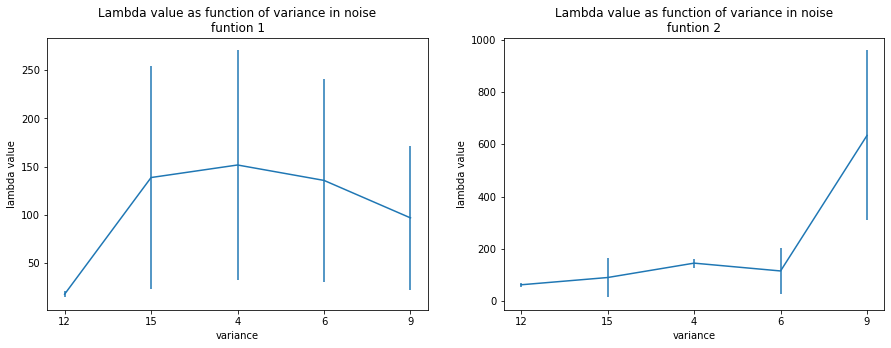

In [12]:
w = np.unique([i.split('_')[-2] for i in trained])
L_1,S_1 = [],[]
L_2,S_2 = [],[]

for i,m in enumerate(w):
    model.load_weights(f"./checkpoints/lambdas_{typ}_{w[i]}_1")
    gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=500)
    ims = np.array(next(gen_batch_val.as_numpy_iterator()))
    
    lambdas = tf.keras.models.Model(model.input,model.get_layer('lambdas').output)
    res = lambdas(ims[0])
    L_1.append(np.mean(np.abs(res)))
    S_1.append(np.std(np.abs(res)))
    
    model.load_weights(f"./checkpoints/lambdas_{typ}_{w[i]}_2")
    lambdas = tf.keras.models.Model(model.input,model.get_layer('lambdas').output)
    res = lambdas(ims[0])
    L_2.append(np.mean(np.abs(res)))
    S_2.append(np.std(np.abs(res)))
    

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.errorbar(w,L_1,S_1)
plt.xlabel('variance')
plt.ylabel('lambda value')
plt.title('Lambda value as function of variance in noise\nfuntion 1')
plt.subplot(122)
plt.errorbar(w,L_2,S_2)
plt.xlabel('variance')
plt.ylabel('lambda value')
plt.title('Lambda value as function of variance in noise\nfuntion 2')
plt.show()

# Comparing vs Perona-Malik

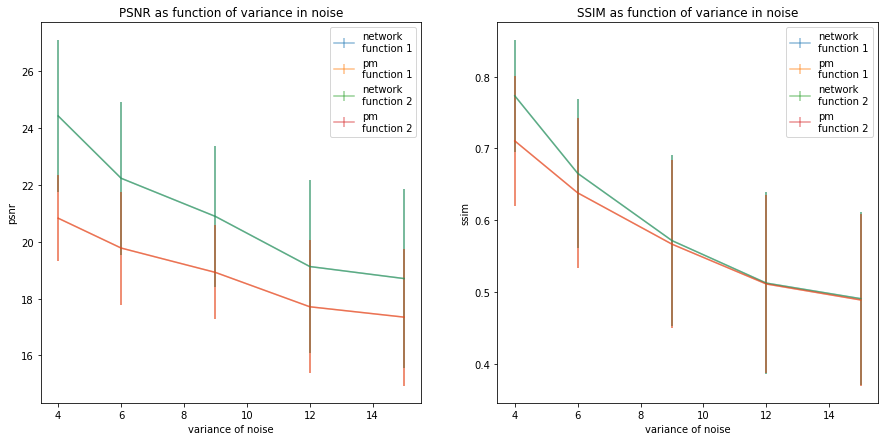

In [15]:
trained = glob(f'./history/lambdas_{typ}*1.npy')
w = np.unique([int(i.split('_')[-2]) for i in trained])
psnr_nn_1,psnr_nn_s_1 = [],[]
psnr_nn_2,psnr_nn_s_2 = [],[]
ssim_nn_1,ssim_nn_s_1 = [],[]
ssim_nn_2,ssim_nn_s_2 = [],[]

psnr_pm_1,psnr_pm_s_1 = [],[]
psnr_pm_2,psnr_pm_s_2 = [],[]
ssim_pm_1,ssim_pm_s_1 = [],[]
ssim_pm_2,ssim_pm_s_2 = [],[]

for i,m in enumerate(w):
    model.load_weights(f"./checkpoints/lambdas_{typ}_{w[i]}_1")
    gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=100)
    ims = np.array(next(gen_batch_val.as_numpy_iterator()))
    
    res = model(ims[0])
    psnr = tf.image.psnr(res,ims[1],1).numpy()
    ssim = tf.image.ssim(res,ims[1],1).numpy()
    psnr_nn_1.append(np.mean(psnr))
    psnr_nn_s_1.append(np.std(psnr))
    ssim_nn_1.append(np.mean(ssim))
    ssim_nn_s_1.append(np.std(ssim))
    
    pm = np.expand_dims([np.squeeze(anisodiff(im,niter=10,lambd=50,option=1)) for im in ims[0]],axis=-1)
    pm = np.asarray(pm,dtype='float32')
    psnr = tf.image.psnr(pm,ims[1],1).numpy()
    ssim = tf.image.ssim(pm,ims[1],1).numpy()
    psnr_pm_1.append(np.mean(psnr))
    psnr_pm_s_1.append(np.std(psnr))
    ssim_pm_1.append(np.mean(ssim))
    ssim_pm_s_1.append(np.std(ssim))
    
    model.load_weights(f"./checkpoints/lambdas_{typ}_{w[i]}_2")
    
    res = model(ims[0])
    psnr = tf.image.psnr(res,ims[1],1).numpy()
    ssim = tf.image.ssim(res,ims[1],1).numpy()
    psnr_nn_2.append(np.mean(psnr))
    psnr_nn_s_2.append(np.std(psnr))
    ssim_nn_2.append(np.mean(ssim))
    ssim_nn_s_2.append(np.std(ssim))
   
    pm = np.expand_dims([np.squeeze(anisodiff(im,niter=10,lambd=50,option=2)) for im in ims[0]],axis=-1)
    pm = np.asarray(pm,dtype='float32')
    psnr = tf.image.psnr(pm,ims[1],1).numpy()
    ssim = tf.image.ssim(pm,ims[1],1).numpy()
    psnr_pm_2.append(np.mean(psnr))
    psnr_pm_s_2.append(np.std(psnr))
    ssim_pm_2.append(np.mean(ssim))
    ssim_pm_s_2.append(np.std(ssim))
    
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.errorbar(w,psnr_nn_1,psnr_nn_s_1,label='network\nfunction 1',alpha=0.5)
plt.errorbar(w,psnr_pm_1,psnr_pm_s_1,label='pm\nfunction 1',alpha=0.5)

plt.errorbar(w,psnr_nn_2,psnr_nn_s_2,label='network\nfunction 2',alpha=0.5)
plt.errorbar(w,psnr_pm_2,psnr_pm_s_2,label='pm\nfunction 2',alpha=0.5)
plt.xlabel('variance of noise')
plt.ylabel('psnr')
plt.title('PSNR as function of variance in noise')
plt.legend()

plt.subplot(122)
plt.errorbar(w,ssim_nn_1,ssim_nn_s_1,label='network\nfunction 1',alpha=0.5)
plt.errorbar(w,ssim_pm_1,ssim_pm_s_1,label='pm\nfunction 1',alpha=0.5)

plt.errorbar(w,ssim_nn_2,ssim_nn_s_2,label='network\nfunction 2',alpha=0.5)
plt.errorbar(w,ssim_pm_2,ssim_pm_s_2,label='pm\nfunction 2',alpha=0.5)
plt.xlabel('variance of noise')
plt.ylabel('ssim')
plt.title('SSIM as function of variance in noise')
plt.legend()
plt.show()